# MLEndLS Part A: Pre-processing

Audio files are downloaded from https://www.kaggle.com/datasets/jesusrequena/mlend-london-sounds

#  1. Problem formulation

London is a vibrant city, full of both natural and man-made noises. One can suppose that different areas of London might be audially different from one another, and therefore may be identified as such by recordings taken in those areas. This is likely a complex problem, and therefore a starting point from a machine learning point of view might be to try to distinguish between sounds that were recorded indoors vs. outdoors.  

This notebook will establish a pipeline to identify, from a dataset of short audio recordings taken around London, whether they are indoors or outdoors.

# 2. Machine Learning pipeline

Broadly, the pipeline is divided into the following stages:  
1. Load data, where the raw data is brought into the notebook, and the relevant files are selected.
2. Transformation, where the audio files are processed to extract features.
4. Validation, where models are compared, hyperparamters tuned, and one model is selected.
3. Testing, where the selected model is tested before deployment.
6. Training, where the model is re-trained on the whole dataset.
4. Deployment (not covered in this notebook), where models are deployed on unseen data.  

Below, the libraries that will be used to address this problem are imported.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os, sys, re, pickle, glob

import IPython.display as ipd
from tqdm import tqdm
import librosa
import librosa.display

import matplotlib.pyplot as plt

import datetime

# 3. Transformation stage

## 3.1 Feature extraction  

The audio data available does not have, on its own, appropriate features for machine learning models. In addition, it is presented in the time domain, i.e. a series of amplitudes of sound against the timestamp.  

### 3.1.1 Basic features

Several basic features of each recording are extracted. The input for each of these is the audio recording, and the output is a single feature for each of the below.:  

- Overall power of the recording.
- Mean of the pitch of the recording.
- Standard deviation of the pitch.
- Fraction of the recording that is voiced.  

### 3.1.2 More advanced features  

The time series data can also be converted to the frequency domain with a Fast Fourier Transform (FFT). This presents a series of new audio features that can be extracted by the Python Librosa library. The below will be explored in this notebook. The input to each of them is the fourier transformed spectrum, and the output is a number of features as indicated:  

- Spectral contrast - 6 features
- Chroma - 13 features
- MFCC - 20 features
- RMS - 1 feature
- Spectral centroid - 1 feature
- Spectral bandwidth - 1 feature
- Spectral flatness - 1 feature
- Spectral rolloff - 1 feature.  

Due to the time constraints of producing this notebook, any further description of the meaning of each of the advanced features will not be conducted.  

## 3.2 Feature selection  

The combination of the extracted basic and advanced features will create 48 features in a dataset of 462 samples. While it may be possible to create a model with this many features, the so-called 'curse of dimensionality' means that there is a risk of overfitting, and therefore only a few features should be selected.  

The process of selection features in this notebook is to visualise the data using boxplots, and select the features that show distinction in their distributions between *indoor* and *outdoor* areas. This is conducted in section 7.6.2.  

The input into this stage is the 48 extracted features, and the output is a subset of these features as determined by the visualisation.

# 4 Dataset

## 4.1 Introduction to dataset  

A dataset of audio recordings from around London has been collected by students at Queen Mary University of London (QMUL) in November 2022, and is called MLEndLS. The attributes of this raw data are:  

1. file_id - the name of the file e.g. '0001.wav' that will be used as an index.
2. area - the area of London where the file was recorded e.g. 'british' = The British Museum.
3. spot - the spot in the area where the recording was made e.g. 'street' = Great Russel Street.
4. in_out - whether the spot is 'indoor' or 'outdoor'.
5. Participant - the ID of the student who made the recording e.g. 'S151'.
6. Audio file recording - the .wav file that contains the approximately 7 second clip recorded by the participant.

The following is known about how the data was collected:  

- Participants were given the choice of 6 areas they could make recordings in.
- Each area contained 6 spots.
- Participants selected a minimum of 3 areas, and made recordings in all 6 spots of each of those areas. (note: one area, 'british' has only 5 spots, as the proposed spot 'room23' was inaccessible at the time of the recordings')
- In each area, there are 3 spots that are 'indoor' and 3 spots that are 'outdoor' (apart from for the 'southbank' area, which is 4:2 in favour of outdoor), so there should be roughly equal numbers of each.

## 4.2 Using data in the notebook  

Below, the filenames are loaded into the notebook and the number of MLEndLS audio files is checked.

In [2]:
sample_path = './Data/wav_files/*.wav'
files = glob.glob(sample_path)
len(files)

2552

There are 2552 files in the MLEndLS dataset. One is known to be a mislabelled location ('room13').

The attributes of each file have been provided in a .csv file, and are loaded into a dataframe below, and the columns renamed.

In [3]:
MLEndLS_df = pd.read_csv('./Data/MLEndLSD.csv').set_index('Public filename') 
column_rename = {'Area' : 'area', 'Spot' : 'spot', 'In_Out' : 'in_out',
                 'Contributor' : 'Participant', 'Duration' : 'duration'}
MLEndLS_df = MLEndLS_df.rename(columns=column_rename)
MLEndLS_df.index.name = 'file_id'
MLEndLS_df.head()

,area,spot,in_out,Participant,duration
file_id,,,,,
0001.wav,british,street,outdoor,S151,9.59
0002.wav,kensington,dinosaur,indoor,S127,7.04
0003.wav,campus,square,outdoor,S18,8.85
0004.wav,kensington,hintze,indoor,S179,7.72
0005.wav,campus,square,outdoor,S176,11.42


In [4]:
MLEndLS_df.loc[MLEndLS_df.spot=='room13']

,area,spot,in_out,Participant,duration
file_id,,,,,
0762.wav,british,room13,indoor,S71,7.5


This will be removed from the dataframe.

In [5]:
to_drop = ['0762.wav']
MLEndLS_df = MLEndLS_df.drop(to_drop)

Summary statistics:

In [6]:
MLEndLS_df.describe(include=[object])

,area,spot,in_out,Participant
count,2551,2551,2551,2551
unique,6,32,2,176
top,campus,square,outdoor,S28
freq,817,218,1310,18


It is noted that there are 32 unique spots in the dataset, whereas it is known that there are a total of 36. Inspection of the spot names shows that some areas have spots with the same name as others.

## 4.3 Data cleaning 

Some of the audio files do not contain any information. Below is some code that will identify these files, by opening them and using the librosa library to calculate the sum of their amplitude.

In [7]:
# Code was run once, included in the notebook for completeness.
# for n, file in enumerate(files):
#     fs = None # Sampling frequency
#     x, fs = librosa.load(files[n], sr=fs)
#     empty_filenames = []
#     if x.sum() == 0:
#         print(file)

No empty files were found in the dataset.

### 4.3.1 Data sampling  

There are 2552 files in the dataset, which will take a long time to pre-process. At least for investigation and feature selection, a smaller dataset will be required. For this, there are the following preferences:  
- Roughly equal number of indoor and outdoor locations.
- Full range of spots.  

As the dataset is balanced for indoor and outdoor, both of the above can be achieved by randomly selecting data, but stratified by spots. The total number of files required will be at least 49, as there are 48 features that are being investigated (see section 4.5). As there are 35 unique spots (36 known and 'room23' removed'), the small dataset will have 350 recordings, i.e. 10 from each spot.  

As some spots have the same names as one another, a new feature will be extracted which combines the spot and area names to create a unique identifier for each spot.

In [8]:
MLEndLS_df['area_spot'] = MLEndLS_df['area'] + MLEndLS_df['spot']
sample_df = MLEndLS_df.groupby(
    'area_spot', group_keys=False).apply(
        lambda x: x.sample(10, random_state=0))
sample_df

,area,spot,in_out,Participant,duration,area_spot
file_id,,,,,,
1564.wav,Euston,forecourt,outdoor,S109,7.67,Eustonforecourt
1526.wav,Euston,forecourt,outdoor,S176,10.37,Eustonforecourt
1733.wav,Euston,forecourt,outdoor,S47,8.42,Eustonforecourt
0319.wav,Euston,forecourt,outdoor,S85,7.46,Eustonforecourt
0707.wav,Euston,forecourt,outdoor,S46,8.01,Eustonforecourt
...,...,...,...,...,...,...
2209.wav,westend,trafalgar,outdoor,S12,7.76,westendtrafalgar
2496.wav,westend,trafalgar,outdoor,S151,9.89,westendtrafalgar
0150.wav,westend,trafalgar,outdoor,S11,7.04,westendtrafalgar


In [9]:
sample_files = [file for file in files
                if file.split('\\')[-1] in sample_df.index]

## 4.4 Data visualisation  

Below is a code cell that previews one of the audio files.

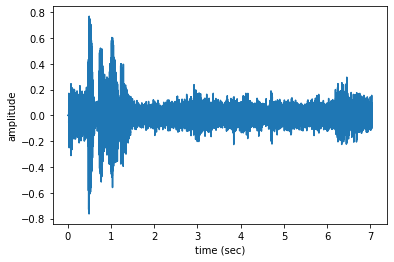

In [10]:
n = 1
fs = None # Sampling frequency
fs = 22050
x, fs = librosa.load(files[n],sr=fs)
t = np.arange(len(x))/fs
plt.plot(t,x)
plt.xlabel('time (sec)')
plt.ylabel('amplitude')
plt.show()
display(ipd.Audio(files[n]))

According to the data collection instructions, each audio file should contain the participant saying 'this is London' at the start of the recording. This can be seen in the above representative example as the considerably higher peaks early in the audio signal.  

Below, the signal undergoes a Fast Fourier Transform (FFT) to transfrom it into the frequency domain.

Text(0, 0.5, 'Amplitude')

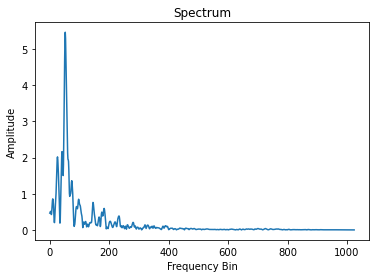

In [11]:
n_fft = 2048
ft = np.abs(librosa.stft(x[:n_fft], hop_length=n_fft+1))
plt.plot(ft)
plt.title('Spectrum')
plt.xlabel('Frequency Bin')
plt.ylabel('Amplitude')

The FFT can be understood as some characteristic frequency peaks. The actual spectral frequency of each peak is not interpretable from the spectrum (it is an arbitrary scale), but this is not required for this ML classification problem.  

Below is shown the Mel spectrogram of the above audio file. This is described here in this link [https://analyticsindiamag.com/a-tutorial-on-spectral-feature-extraction-for-audio-analytics/].

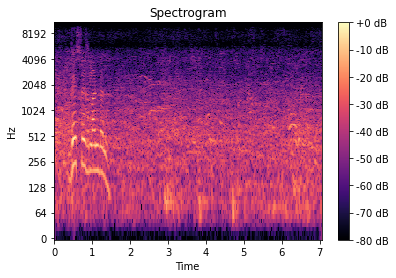

In [12]:
spec = np.abs(librosa.stft(x, hop_length=512))
spec = librosa.amplitude_to_db(spec, ref=np.max)
librosa.display.specshow(spec, sr=fs, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.show()

The Mel spectrogram is an image of the data as it appears to human ears. One thing that is clear is that the data is not equivariate, and therefore a convolutional neural network should not be used on the raw data. However, the time domain should not be worked in (the time of sounds is arbitrary), and thus the sound should be transformed to the frequency domain for feature extraction.

## 4.5 Feature extraction  

The features that will be used to predict whether sound was recorded indoors or outdoors are extracted from audio recordings.  

The code to extract the files will **not** execute every time the notebook is run, as it will take over 30 minutes. The extracted features have been saved in '.csv' files in section 4.5.3, which is later re-imported into the notebook in section 4.6.  

### 4.5.1 Basic features  

First, the librosa library is used to extract the pitch, as well as the portions to the recording that contain voices.


In [13]:
def getPitch(x,fs,winLen=0.02):
    # Used within getXy_basic below.
    p = winLen*fs
    frame_length = int(2**int(p-1).bit_length())
    hop_length = frame_length//2
    f0, voiced_flag, voiced_probs = librosa.pyin(y=x, fmin=80, fmax=450, sr=fs,
                                                 frame_length=frame_length,hop_length=hop_length)
    return f0,voiced_flag

In [14]:
def getXy_basic(files,labels_file, scale_audio=False, onlySingleDigit=False):
    X_1, X_2, y =[], [], []
    for file in tqdm(files):
        fileID = file.split('\\')[-1]
        file_name = file.split('\\')[-1]
        yi = labels_file.loc[fileID]['in_out']=='indoor'

        fs = None # if None, fs would be 22050.
        x, fs = librosa.load(file,sr=fs)

        # Without scaled audio.
        f0, voiced_flag = getPitch(x,fs,winLen=0.02)

        power = np.sum(x**2)/len(x)
        pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0))<1 else 0
        pitch_std  = np.nanstd(f0) if np.mean(np.isnan(f0))<1 else 0
        voiced_fr = np.mean(voiced_flag)

        xi1 = [power,pitch_mean,pitch_std,voiced_fr]
        X_1.append(xi1)

        # With scaled audio.
        x = x/np.max(np.abs(x))
        f0, voiced_flag = getPitch(x,fs,winLen=0.02)

        power = np.sum(x**2)/len(x)
        pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0))<1 else 0
        pitch_std  = np.nanstd(f0) if np.mean(np.isnan(f0))<1 else 0
        voiced_fr = np.mean(voiced_flag)

        xi2 = [power,pitch_mean,pitch_std,voiced_fr]

        X_2.append(xi2)
        y.append(yi)

    return np.array(X_1), np.array(X_2), np.array(y)

In [15]:
# Test getXy_basic
X_1, X_2, y_1 = getXy_basic(['./Data/wav_files\\0011.wav',], labels_file=MLEndLS_df, scale_audio=True, onlySingleDigit=True)
print(X_1)
print(X_2)
print(y_1)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.12s/it]

[[1.05418355e-03 2.36538415e+02 1.28637922e+01 8.11258278e-02]]
[[6.08219070e-03 2.36538415e+02 1.28637922e+01 8.11258278e-02]]
[False]


X_1, X_2 and y_1 contain the right kind of numbers.

### 4.5.2 STFT  

A number of features can be extracted from the data via the librosa library. Due to the time constraints of this project, domain understanding of these will not be sought. Other methods will be used to determine useful potential features for model fitting. The 'librosa.feature' methods give a total of 44 potential features to investigate. The code is run twice, once with, and once without audio scaling. Both will be investigated.

In [16]:
def getXy_STFT(files,labels_file, scale_audio=False):
    X,y =[],[]
    for file in tqdm(files):
        fileID = file.split('\\')[-1]
        file_name = file.split('\\')[-1]
        yi = labels_file.loc[fileID]['in_out']=='indoor'

        fs = 22050 # if None, fs would be 22050
        x, fs = librosa.load(file,sr=fs)
        if scale_audio: x = x/np.max(np.abs(x))
        n_fft = 2048
        ft = np.abs(librosa.stft(x[:n_fft], hop_length=n_fft+1))
        sc = librosa.feature.spectral_contrast(S=ft, sr=fs) # features 0-6
        ch = librosa.feature.chroma_stft(S=ft, sr=fs) # features 7-19
        mf = librosa.feature.mfcc(S=ft, sr=fs) # features 20-39
        rm = librosa.feature.rms(S=ft) # feature 40
        st = librosa.feature.spectral_centroid(S=ft, sr=fs) # feature 41
        sb = librosa.feature.spectral_bandwidth(S=ft, sr=fs) # features 42
        sf = librosa.feature.spectral_flatness(S=ft) # feature 43
        sr = librosa.feature.spectral_rolloff(S=ft, sr=fs) # feature 44

        features = [sc.T, ch.T, mf.T, rm.T, st.T, sb.T, sf.T, sr.T]

        xi = np.concatenate((features), axis=1)[0]

        X.append(xi)
        y.append(yi)

    return np.array(X),np.array(y)

In [17]:
# Test getXy_STFT.
X_3, y_3 = getXy_STFT(['./Data/wav_files\\0011.wav',], labels_file=MLEndLS_df, scale_audio=True)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.81it/s]


In [18]:
print(X_3)
print(y_3)

[[8.72988071e+00 5.57060383e+00 5.67377107e+00 1.76095701e+01
  1.41515773e+01 1.71207832e+01 4.00667363e+01 9.47702587e-01
  9.40830886e-01 9.57732975e-01 8.74859750e-01 8.95007730e-01
  1.00000000e+00 9.69987929e-01 7.74199188e-01 6.56552255e-01
  6.91784561e-01 8.57071757e-01 9.12629485e-01 5.90635061e+00
  6.38749599e+00 4.32825994e+00 3.19170070e+00 2.53154421e+00
  2.37222028e+00 2.38994622e+00 2.34565115e+00 2.07340145e+00
  2.37730312e+00 2.10855055e+00 1.63516068e+00 1.18164778e+00
  7.49937832e-01 6.90988243e-01 8.92681837e-01 1.09949148e+00
  1.04342103e+00 9.65471268e-01 9.52870131e-01 1.00320878e-02
  1.79235075e+03 2.12025119e+03 1.25633217e-02 3.74677734e+03]]
[False]


The output of getXy_STFT looks good.

In [19]:
X_4, y_4 = getXy_STFT(['./Data/wav_files\\0011.wav',], labels_file=MLEndLS_df, scale_audio=False)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 60.86it/s]


In [20]:
# Create test dataframes
df_basic_scaled = pd.DataFrame(X_1)
df_basic_scaled['indoor'] = y_1
df_basic_scaled = df_basic_scaled.rename(
    columns={0:'power', 1:'pitch_mean', 2:'pitch_std', 3:'voiced_fr'})

df_basic_unscaled = pd.DataFrame(X_2)
df_basic_unscaled['indoor'] = y_1
df_basic_unscaled = df_basic_unscaled.rename(
    columns={0:'power', 1:'pitch_mean', 2:'pitch_std', 3:'voiced_fr'})
df_stft_scaled = pd.DataFrame(X_3)
df_stft_unscaled = pd.DataFrame(X_4)

### 4.5.3 Combining features  

Below the basic and FFT features are combined into 2 dataframes, one with scaled audio and one without. Each of these is saved to a '.csv' file, so that repeated iterations of the notebook will not need to run the functions. The files have been manually renamed in the folder to avoid accidentally writing over them.

In [21]:
# Test combining and saving the dataframes.
df_scaled = pd.concat([df_stft_scaled, df_basic_scaled], axis=1)
df_scaled.to_csv('Data/Feature_csv_files/scaled_features.csv')
df_unscaled = pd.concat([df_stft_unscaled, df_basic_unscaled], axis=1)
df_unscaled.to_csv('Data/Feature_csv_files/unscaled_features.csv')

The expected CSV files were created and saved.  

## 4.5.4 Full run

Now that the functions and code snippets have been tested on a single file, the full list of 360 sample files will be processed and the resulting CSV files saved. This takes some time, so should not be run every time the notebook is run. Therefore, the snippets will be commented out.

In [22]:
print('Run started at:')
print(datetime.datetime.now().strftime('%H:%M:%S'))
# Code was run once, presented in the notebook for completeness.
fileID = [file.split('\\')[-1] for file in sample_files]

Run started at:
15:58:37


In [23]:
# Code was run once, presented in the notebook for completeness.
X_1, X_2, y_1 = getXy_basic(sample_files, labels_file=MLEndLS_df, scale_audio=True, onlySingleDigit=True)

100%|████████████████████████████████████████████████████████████████████████████████| 360/360 [27:17<00:00,  4.55s/it]


In [24]:
# Code was run once, presented in the notebook for completeness.
df_basic_scaled = pd.DataFrame(X_1, index=fileID)
df_basic_scaled['indoor'] = y_1
df_basic_scaled = df_basic_scaled.rename(
    columns={0:'power', 1:'pitch_mean', 2:'pitch_std', 3:'voiced_fr'})

df_basic_unscaled = pd.DataFrame(X_2, index=fileID)
df_basic_unscaled['indoor'] = y_1
df_basic_unscaled = df_basic_unscaled.rename(
    columns={0:'power', 1:'pitch_mean', 2:'pitch_std', 3:'voiced_fr'})

In [25]:
# Code was run once, presented in the notebook for completeness.
X_3, y_3 = getXy_STFT(sample_files, labels_file=MLEndLS_df, scale_audio=True)

  0%|                                                                                          | 0/360 [00:00<?, ?it/s]C:\Users\minor\anaconda3\lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
100%|████████████████████████████████████████████████████████████████████████████████| 360/360 [00:08<00:00, 40.62it/s]


In [26]:
# Code was run once, presented in the notebook for completeness.
df_stft_scaled = pd.DataFrame(X_3,index=fileID)

In [27]:
# Code was run once, presented in the notebook for completeness.
X_4, y_4 = getXy_STFT(sample_files, labels_file=MLEndLS_df, scale_audio=False)

  0%|                                                                                          | 0/360 [00:00<?, ?it/s]C:\Users\minor\anaconda3\lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
100%|████████████████████████████████████████████████████████████████████████████████| 360/360 [00:08<00:00, 41.19it/s]


In [28]:
# Code was run once, presented in the notebook for completeness.
df_stft_unscaled = pd.DataFrame(X_4, index=fileID)

In [29]:
# Code was run once, presented in the notebook for completeness.
df_scaled = pd.concat([df_stft_scaled, df_basic_scaled], axis=1)
df_scaled.to_csv('Data/Feature_csv_files/scaled_features.csv')
df_unscaled = pd.concat([df_stft_unscaled, df_basic_unscaled], axis=1)
df_unscaled.to_csv('Data/Feature_csv_files/unscaled_features.csv')
print('Run ended at:')
print(datetime.datetime.now().strftime('%H:%M:%S'))

Run ended at:
16:26:12


The run took approximately 30 minutes.